# Maftools analysis

## Requires having run vcf2maf on the output of vk clean with a command like this:
- perl vcf2maf.pl --input-vcf variants.vcf --output-maf variants.maf --ref-fasta /path/to/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa --cache-version 93 --species homo_sapiens --ncbi-build GRCh37 --retain-info AO,NS

In [1]:
# try:
#     import varseek as vk
# except ImportError:
#     print("varseek not found, installing...")
#     !pip install -U -q varseek
# try:
#     import RLSRWP_2025
# except ImportError:
#     print("RLSRWP_2025 not found, installing...")
#     !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git

In [ ]:
import os
from rpy2.robjects import pandas2ri, r, globalenv
import pandas as pd
import sys
from varseek.utils import download_box_url  # for functions used in both varseek and here
# from RLSRWP_2025 import ...  # for functions only used here
from RLSRWP_2025.constants import box_links_dict

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025

### File path definitions and imports

In [ ]:
vk_count_out_dir = os.path.join(RLSRWP_2025_dir, "data", "vk_count_out_fig1")
maf_path = os.path.join(vk_count_out_dir, "variants.maf")

out_dir = os.path.join(vk_count_out_dir, "analysis", "maftools_figs")

### Download the MAF file

In [ ]:
if not os.path.exists(maf_path):
    download_box_url(box_links_dict["glioblastoma_smartseq_maf"], output_file_name=maf_path)

os.makedirs(out_dir, exist_ok=True)

### Load in rpy2

In [4]:
%load_ext rpy2.ipython

In [5]:
# Activate the automatic conversion between pandas and R objects
pandas2ri.activate()

### Load in maftools

In [ ]:
%%R
library(maftools)

### Load in data

In [24]:
%%R -i maf_path,out_dir
cosmic_maf = read.maf(maf = maf_path)  # removeDuplicatedVariants=FALSE if needed, but I don't think it is

-Reading
-Validating
-Silent variants: 13 
-Summarizing
-Processing clinical data
--Missing clinical data
-Finished in 0.107s elapsed (0.026s cpu) 


## 7.1 Plotting MAF summary

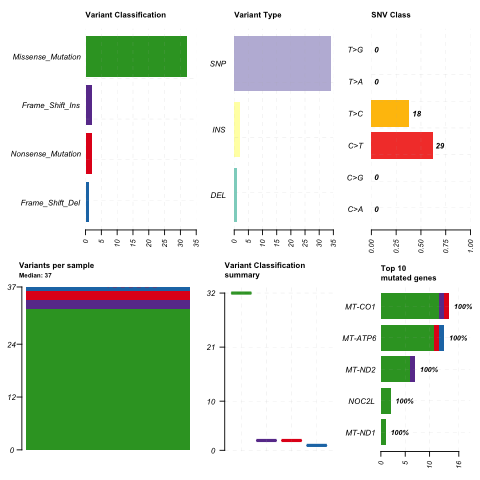

In [44]:
%%R
maftools_summary_path <- file.path(out_dir, "maftools_summary.pdf")
pdf(maftools_summary_path); {plotmafSummary(maf = cosmic_maf, rmOutlier = TRUE, addStat = 'median', dashboard = TRUE, titvRaw = FALSE)}; dev.off()
plotmafSummary(maf = cosmic_maf, rmOutlier = TRUE, addStat = 'median', dashboard = TRUE, titvRaw = FALSE)

## 7.2 Oncoplots

In addition: Warning messages:
1: In min(x) : no non-missing arguments to min; returning Inf
2: In max(x) : no non-missing arguments to max; returning -Inf
3: In min(x) : no non-missing arguments to min; returning Inf
4: In max(x) : no non-missing arguments to max; returning -Inf


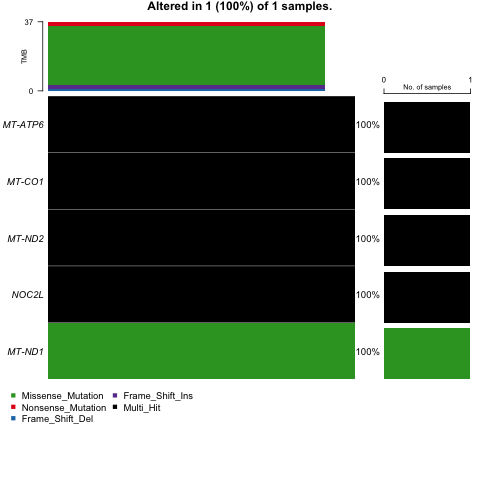

In [67]:
%%R
oncoplot_path <- file.path(out_dir, "oncoplot.pdf")
pdf(maftools_summary_path); {oncoplot(maf = cosmic_maf, top = 10)}; dev.off()
oncoplot(maf = cosmic_maf, top = 10)

## 7.6 Compare mutation load against TCGA cohorts

Capture size [TCGA]:  35.8
Capture size [Input]: 50
Performing pairwise t-test for differences in mutation burden (per MB)..
Capture size [TCGA]:  35.8
Capture size [Input]: 50
Performing pairwise t-test for differences in mutation burden (per MB)..
In addition: Warning messages:
1: In FUN(X[[i]], ...) : Removed 0 samples with zero mutations.
2: In FUN(X[[i]], ...) : Removed 0 samples with zero mutations.


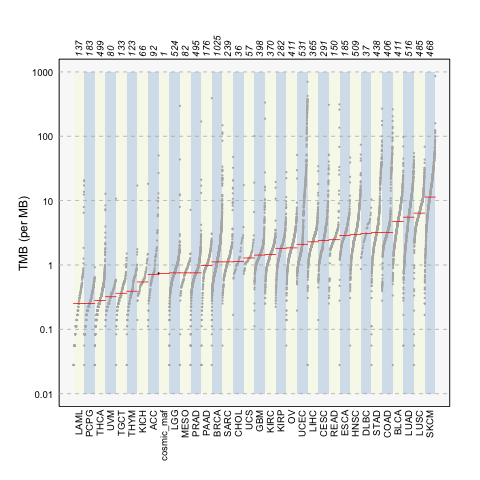

In [47]:
# %%R
# tcga_plot_path <- file.path(out_dir, "tcga_plot.pdf")
# pdf(tcga_plot_path); {cosmic_maf.mutload = tcgaCompare(maf = cosmic_maf, cohortName = 'cosmic_maf', logscale = TRUE, capture_size = 50)}; dev.off()
# cosmic_maf.mutload = tcgaCompare(maf = cosmic_maf, cohortName = 'cosmic_maf', logscale = TRUE, capture_size = 50)

## 9.1 Somatic Interactions

In [66]:
%%R
interactions_path <- file.path(out_dir, "interactions.pdf")

tryCatch({
    pdf(interactions_path); {somaticInteractions(maf = cosmic_maf, top = 25, pvalue = c(0.05, 0.1))}; dev.off()
    somaticInteractions(maf = cosmic_maf, top = 25, pvalue = c(0.05, 0.1))
}, error = function(e) {
    message(e$message)
    try(dev.off(), silent = TRUE)
})

quartz_off_screen 
                3 


Minimum two genes required!


## 9.2 Detecting cancer driver genes based on positional clustering

In [ ]:
%%R
oncodriveCLUST_path <- file.path(out_dir, "oncodriveCLUST.pdf")
cosmic_maf.sig = oncodrive(maf = cosmic_maf, AACol = 'Protein_Change', minMut = 5, pvalMethod = 'zscore')
pdf(oncodriveCLUST_path); {plotOncodrive(res = cosmic_maf.sig, fdrCutOff = 0.1, useFraction = TRUE, labelSize = 0.5)}; dev.off()
plotOncodrive(res = cosmic_maf.sig, fdrCutOff = 0.1, useFraction = TRUE, labelSize = 0.5)

## 9.7 Drug-Gene Interactions

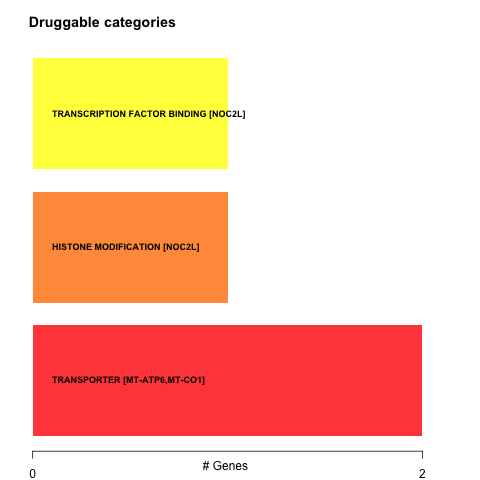

In [84]:
%%R
drug_interactions_path <- file.path(out_dir, "drug_interactions.pdf")
pdf(oncodriveCLUST_path); {drugInteractions(maf = cosmic_maf, fontSize = 0.75)}; dev.off()
dgi = drugInteractions(maf = cosmic_maf, fontSize = 0.75)

## 9.8 Oncogenic Signaling Pathways

In [ ]:
%%R
pathways_path <- file.path(out_dir, "pathways.pdf")

# wrapped in tryCatch because it will give an error if no pathways are altered
tryCatch({
    pws <- pathways(maf = cosmic_maf, plotType = 'treemap')
    pdf(pathways_path); {plotPathways(maf = cosmic_maf, pathlist = pws)}; dev.off()
    plotPathways(maf = cosmic_maf, pathlist = pws)
}, error = function(e) {
    message(e$message)
    try(dev.off(), silent = TRUE)
})